Use the library of identified sequences to detect the feature in each run. Build a table of each feature's attributes and their decoy.

In [743]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import sqlite3
import peakutils
from scipy import signal
import matplotlib.pyplot as plt

In [744]:
FILE_IDX_FOR_ANALYSIS = 0

In [745]:
SEQUENCE_FILE_COUNTS_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/sequence-charge-file-counts-df.pkl'

In [746]:
sequence_file_counts_df = pd.read_pickle(SEQUENCE_FILE_COUNTS_FILE_NAME)

In [747]:
sequence_file_counts_df[sequence_file_counts_df.file_idxs.apply(lambda x: 0 in x)].sample(n=20)  # use not in x for sequences missed in this file

,sequence,charge,number_of_files,file_idxs
14319,IVSSSDVGHDEYSTQSLVK,2,20,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
28387,VLGENYTLEDEEDSQICTVGR,2,20,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
5109,DYIHVMDLADGHVVAMEK,3,19,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
10975,GTEGMEPEEGVTVESQPQVK,2,20,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
29898,WNTDNTLGTEIAIEDQICQGLK,3,20,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
6050,EGMAALQSDPWQQELYR,2,16,"[0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ..."
16431,LLETTDRPDGHQNNLR,2,20,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
6754,EMVPEFVVPDLTGFK,2,19,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14,..."
31211,n[42.0106]MEVVEAAAAQLETLK,2,15,"[0, 3, 4, 5, 6, 7, 9, 10, 12, 14, 15, 16, 17, ..."
4712,DSENLASPSEYPENGER,2,20,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [748]:
SEQUENCE_ROW_IDX_FOR_ANALYSIS = 12970

In [749]:
EXPERIMENT_SEQUENCE_ATTRIBS_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/training-sets/experiment-sequence-charge-attribs-df.pkl'

In [750]:
experiment_sequence_attribs_df = pd.read_pickle(EXPERIMENT_SEQUENCE_ATTRIBS_FILE_NAME)

In [751]:
experiment_sequence_attribs_df.head()

,sequence,charge,theoretical_mz,experiment_scan,experiment_scan_peak_width,experiment_rt,experiment_rt_peak_width,experiment_intensity
0,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,1184.1049,73.911301,57.626667,602.012681,18.706667,108754.444444
1,AAAAAAAAAPAAAATAPTTAATTAATAAQ,3,789.7394,335.868469,56.366667,609.864140,5.030000,29377.333333
2,AAAAAAAAVPSAGPAGPAPTSAAGR,2,1016.0286,160.291329,64.555556,489.973155,6.357111,58456.622222
3,AAAAALSQQQSLQER,2,785.9075,496.361511,45.912500,375.039574,6.140000,57092.250000
4,AAAAATVVPPMVGGPPFVGPVGFGPGDR,3,864.1171,707.537580,48.382593,1039.861047,16.666296,50988.518519


In [752]:
# use the run-0 model to find AAAAATVVPPMVGGPPFVGPVGFGPGDR, charge 3 in the raw data of the file idx
RUN_MZ_MODEL_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/trained-models/file-{}-mz-model.pkl'.format(FILE_IDX_FOR_ANALYSIS)
RUN_SCAN_MODEL_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/trained-models/file-{}-scan-model.pkl'.format(FILE_IDX_FOR_ANALYSIS)
RUN_RT_MODEL_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/trained-models/file-{}-rt-model.pkl'.format(FILE_IDX_FOR_ANALYSIS)

In [753]:
with open(RUN_MZ_MODEL_FILE_NAME, 'rb') as file:
    mz_estimator = pickle.load(file)
with open(RUN_SCAN_MODEL_FILE_NAME, 'rb') as file:
    scan_estimator = pickle.load(file)
with open(RUN_RT_MODEL_FILE_NAME, 'rb') as file:
    rt_estimator = pickle.load(file)

In [754]:
# gather the sequence attributes to plug into each model
sequence_df = pd.DataFrame(experiment_sequence_attribs_df.iloc[SEQUENCE_ROW_IDX_FOR_ANALYSIS]).transpose()

In [755]:
sequence_df

,sequence,charge,theoretical_mz,experiment_scan,experiment_scan_peak_width,experiment_rt,experiment_rt_peak_width,experiment_intensity
12970,IFVGNVSAACTSQELR,2,875.937,367.806,35.4034,623.104,7.3356,472141


In [756]:
sequence_estimation_attribs_df = sequence_df[['theoretical_mz','experiment_rt','experiment_scan','experiment_intensity']]
sequence_estimation_attribs = sequence_estimation_attribs_df.values

In [757]:
sequence_estimation_attribs

array([[875.937, 623.1044293358847, 367.80587197718785, 472141.48]],
      dtype=object)

In [758]:
# estimate the raw monoisotopic m/z
mz_delta_estimated = mz_estimator.predict(sequence_estimation_attribs)
estimated_monoisotopic_mz = sequence_estimation_attribs_df.iloc[0].theoretical_mz - mz_delta_estimated[0]
estimated_monoisotopic_mz

876.4334042332906

In [759]:
# estimate the raw monoisotopic scan
scan_estimated = scan_estimator.predict(sequence_estimation_attribs)
estimated_scan_apex = scan_estimated[0]
estimated_scan_apex

368.2707040026724

In [760]:
# estimate the raw monoisotopic RT
rt_estimated = rt_estimator.predict(sequence_estimation_attribs)
estimated_rt_apex = rt_estimated[0]
estimated_rt_apex

616.668238026131

Look in the raw data for a feature at these coordinates

In [853]:
# the width to use for intensity descent, in m/z
MZ_TOLERANCE_PPM = 20  # +/- this amount
MZ_TOLERANCE_PERCENT = MZ_TOLERANCE_PPM * 10**-4
MS1_PEAK_DELTA = estimated_monoisotopic_mz * MZ_TOLERANCE_PERCENT / 100

In [854]:
MS1_PEAK_DELTA

0.017528668084665813

In [855]:
# Mass difference between Carbon-12 and Carbon-13 isotopes, in Da. For calculating the spacing between isotopic peaks.
CARBON_MASS_DIFFERENCE = 1.003355

# the collision energy to distinguish ms1 and ms2 frames
MS1_COLLISION_ENERGY = 10

In [856]:
# takes a numpy array of intensity, and another of mz
def mz_centroid(_int_f, _mz_f):
    return ((_int_f/_int_f.sum()) * _mz_f).sum()

In [857]:
NUMBER_OF_ISOTOPES = 7     # the number of isotopes to look for in the m/z dimension - the theoretical model includes 7 (the monoisotopic plus 6 isotopes)

expected_spacing_mz = CARBON_MASS_DIFFERENCE / sequence_df.iloc[0].charge

In [858]:
# distance for looking either side of the scan and RT apex, based on the other times this sequence has been seen in this experiment
RT_WIDTH = sequence_df.iloc[0].experiment_rt_peak_width
SCAN_WIDTH = sequence_df.iloc[0].experiment_scan_peak_width

In [859]:
feature_region_mz_lower = estimated_monoisotopic_mz - MS1_PEAK_DELTA
feature_region_mz_upper = estimated_monoisotopic_mz + (NUMBER_OF_ISOTOPES * expected_spacing_mz) + MS1_PEAK_DELTA
scan_lower = estimated_scan_apex - (2 * SCAN_WIDTH)
scan_upper = estimated_scan_apex + (2 * SCAN_WIDTH)
rt_lower = estimated_rt_apex - (2 * RT_WIDTH)
rt_upper = estimated_rt_apex + (2 * RT_WIDTH)
print("mz: {}-{}, scan: {}-{}, rt: {}-{}".format(round(feature_region_mz_lower,4), round(feature_region_mz_upper,4), int(scan_lower), int(scan_upper), round(rt_lower,1), round(rt_upper,1)))

mz: 876.4159-879.9627, scan: 297-439, rt: 602.0-631.3


In [860]:
# find the converted database file name for file idx 0
MAPPING_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/percolator_mapping_df.pkl'
mapping_df = pd.read_pickle(MAPPING_FILE_NAME)

In [861]:
run_name = mapping_df[mapping_df.file_idx == FILE_IDX_FOR_ANALYSIS].iloc[0].run_name
run_name

'190719_Hela_Ecoli_1to3_06-recalibrated'

In [862]:
db_name = run_name.replace('-recalibrated', '-converted.sqlite')

In [863]:
CONVERTED_DATABASE_NAME = '/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/converted-databases/{}'.format(db_name)
CONVERTED_DATABASE_NAME

'/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/converted-databases/190719_Hela_Ecoli_1to3_06-converted.sqlite'

In [864]:
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
ms1_frame_properties_df = pd.read_sql_query("select frame_id,retention_time_secs from frame_properties where retention_time_secs >= {} and retention_time_secs <= {} and collision_energy == {} order by retention_time_secs".format(rt_lower, rt_upper, MS1_COLLISION_ENERGY), db_conn)
db_conn.close()
ms1_frame_ids = tuple(ms1_frame_properties_df.frame_id)

In [865]:
# extract the raw data within this area of interest
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
feature_region_raw_points_df = pd.read_sql_query("select frame_id,mz,scan,intensity,retention_time_secs from frames where mz >= {} and mz <= {} and scan >= {} and scan <= {} and retention_time_secs >= {} and retention_time_secs <= {} and frame_id in {}".format(feature_region_mz_lower, feature_region_mz_upper, scan_lower, scan_upper, rt_lower, rt_upper, ms1_frame_ids), db_conn)
db_conn.close()

In [866]:
sequence_name = sequence_df.iloc[0].sequence
sequence_charge = sequence_df.iloc[0].charge

In [867]:
# a wider view for context
feature_region_mz_wide_lower = feature_region_mz_lower - 1
feature_region_mz_wide_upper = feature_region_mz_upper + 1
scan_wide_lower = scan_lower - 30
scan_wide_upper = scan_upper + 30
rt_wide_lower = estimated_rt_apex - 1
rt_wide_upper = estimated_rt_apex + 1

# extract the raw data within this area of interest
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
wide_feature_region_raw_points_df = pd.read_sql_query("select frame_id,mz,scan,intensity,retention_time_secs from frames where mz >= {} and mz <= {} and scan >= {} and scan <= {} and retention_time_secs >= {} and retention_time_secs <= {} and frame_id in {}".format(feature_region_mz_wide_lower, feature_region_mz_wide_upper, scan_wide_lower, scan_wide_upper, rt_wide_lower, rt_wide_upper, ms1_frame_ids), db_conn)
db_conn.close()

In [868]:
isotope_peaks_l = []
isotope_raw_points_l = []
# derive peaks for the monoisotopic and the isotopes
mz = estimated_monoisotopic_mz
for isotope_idx in range(NUMBER_OF_ISOTOPES):
    estimated_isotope_midpoint = mz + (isotope_idx * expected_spacing_mz)
    isotope_mz_lower = estimated_isotope_midpoint - MS1_PEAK_DELTA
    isotope_mz_upper = estimated_isotope_midpoint + MS1_PEAK_DELTA
    isotope_raw_points_df = feature_region_raw_points_df[(feature_region_raw_points_df.mz >= isotope_mz_lower) & (feature_region_raw_points_df.mz <= isotope_mz_upper)]
    # add the isotope's raw points to the list
    isotope_raw_points_l.append(isotope_raw_points_df)
    # centroid the raw points to get the peak for the isotope
    isotope_raw_points_a = isotope_raw_points_df[['mz','intensity']].values
    mz_cent = mz_centroid(isotope_raw_points_a[:,1], isotope_raw_points_a[:,0])
    summed_intensity = isotope_raw_points_a[:,1].sum()
    # add the peak to the list of isotopic peaks
    isotope_peaks_l.append((mz_cent, summed_intensity))
    if isotope_idx == 0:
        # set the m/z reference point to be the monoisotope's centroided m/z
        mz = mz_cent
isotope_peaks_df = pd.DataFrame(isotope_peaks_l, columns=['mz_centroid','summed_intensity'])

In [869]:
estimated_monoisotopic_mz

876.4334042332906

In [870]:
isotope_peaks_df

,mz_centroid,summed_intensity
0,876.434936,448176.0
1,876.936745,484499.0
2,877.438275,372004.0
3,877.940101,229030.0
4,878.442763,155617.0
5,878.947412,136372.0
6,879.446159,224008.0


In [871]:
len(isotope_raw_points_l)

7

In [872]:
# assumes the isotope's raw points have already been flattened to a particular dimension (e.g. scan, RT, m/z) and 
# sorted by ascending order in that dimension
def calculate_isotope_metrics(flattened_points_df, estimated_apex, estimated_peak_width):
    results_d = {}
    curve_fit = False
    # apply a filter to make curve fitting easier
    flattened_points_df['filtered_intensity'] = signal.savgol_filter(flattened_points_df.intensity, window_length=11, polyorder=3)
    # determine whether there's more than one peak
    peak_maxima_indexes = peakutils.indexes(flattened_points_df.filtered_intensity.values, thres=0.05, min_dist=estimated_peak_width/4, thres_abs=False)
    print("there are {} peaks".format(len(peak_maxima_indexes)))
    results_d["number_of_peaks"] = len(peak_maxima_indexes)
    results_d["original_intensity_filtered"] = flattened_points_df.filtered_intensity.values
    # if there's more than one peak, we need to trim the data to a single peak
    if len(peak_maxima_indexes) > 1:
        peaks_df = flattened_points_df.iloc[peak_maxima_indexes].copy()
        # find the peak closest to the estimated apex
        peaks_df['apex_delta'] = abs(peaks_df.x - estimated_apex)
        peaks_df.loc[peaks_df.apex_delta.idxmin()]
        peak_idx = peaks_df.apex_delta.idxmin()

        valleys_idx = peakutils.indexes(-flattened_points_df.filtered_intensity.values, thres=0.001, min_dist=estimated_peak_width/4, thres_abs=False)
        valleys_df = flattened_points_df.iloc[valleys_idx].copy()
        # find the closest valley above the peak
        if max(valleys_idx) > peak_idx:
            valley_idx_above = valleys_idx[valleys_idx > peak_idx].min()
            base_upper = valleys_df.loc[valley_idx_above].x
            flattened_points_df = flattened_points_df[(flattened_points_df.x <= base_upper)]
        else:
            print("could not find a valley above the peak")
            valley_idx_above = -1
        # find the closest valley below the peak
        if min(valleys_idx) < peak_idx:
            valley_idx_below = valleys_idx[valleys_idx < peak_idx].max()
            base_lower = valleys_df.loc[valley_idx_below].x
            flattened_points_df = flattened_points_df[(flattened_points_df.x >= base_lower)]
        else:
            print("could not find a valley below the peak")
            valley_idx_below = -1

        results_d["peaks_df"] = peaks_df
        results_d["selected_peak_idx"] = peak_idx
        results_d["peak_maxima_indexes"] = peak_maxima_indexes
        results_d["valleys_df"] = valleys_df
        results_d["valley_idx_below"] = valley_idx_below
        results_d["valley_idx_above"] = valley_idx_above
        
    # fit a gaussian curve to the data
    gaussian_params = peakutils.peak.gaussian_fit(flattened_points_df.x.values, flattened_points_df.filtered_intensity.values, center_only=False)
    curve_fit = True
    apex_x = gaussian_params[1]
    std_dev = abs(gaussian_params[2])
    fitted_intensity_values = peakutils.peak.gaussian(flattened_points_df.x.values, gaussian_params[0], gaussian_params[1], gaussian_params[2])
    fitted_curve_df = flattened_points_df.copy()
    fitted_curve_df['fitted_intensity'] = fitted_intensity_values
    area_under_curve = fitted_intensity_values.sum()
    intensity_at_apex = peakutils.peak.gaussian(apex_x, gaussian_params[0], gaussian_params[1], gaussian_params[2])

    # calculate the r-squared value of the fitted curve (source: https://stackoverflow.com/a/37899817/1184799)
    residuals = flattened_points_df.intensity - fitted_intensity_values
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((flattened_points_df.intensity - np.mean(flattened_points_df.intensity))**2)
    r_squared = 1 - (ss_res / ss_tot)

    # calculate the peak symmetry
    lhs_auc = flattened_points_df[(flattened_points_df.x <= apex_x)].intensity.sum()
    rhs_auc = flattened_points_df[(flattened_points_df.x > apex_x)].intensity.sum()
    peak_symmetry = lhs_auc / rhs_auc

    # collate the metrics into the results dictionary
    results_d["std_dev"] = std_dev
    results_d["full_width_half_max"] = 2.355 * std_dev  # https://ned.ipac.caltech.edu/level5/Leo/Stats2_3.html
    results_d["base_width"] = 6 * std_dev  # https://ned.ipac.caltech.edu/level5/Leo/Stats2_3.html
    results_d["base_lower"] = apex_x - (3 * std_dev)  # https://ned.ipac.caltech.edu/level5/Leo/Stats2_3.html
    results_d["base_upper"] = apex_x + (3 * std_dev)  # https://ned.ipac.caltech.edu/level5/Leo/Stats2_3.html
    results_d["r_squared"] = r_squared
    results_d["apex"] = apex_x
    results_d["intensity_at_apex"] = intensity_at_apex
    results_d["fitted"] = curve_fit
    results_d["area_under_curve"] = area_under_curve
    results_d["peak_symmetry"] = peak_symmetry
    results_d["fitted_curve_df"] = fitted_curve_df

    return results_d

In [873]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
# Rescale to values between 0 and 1 
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)

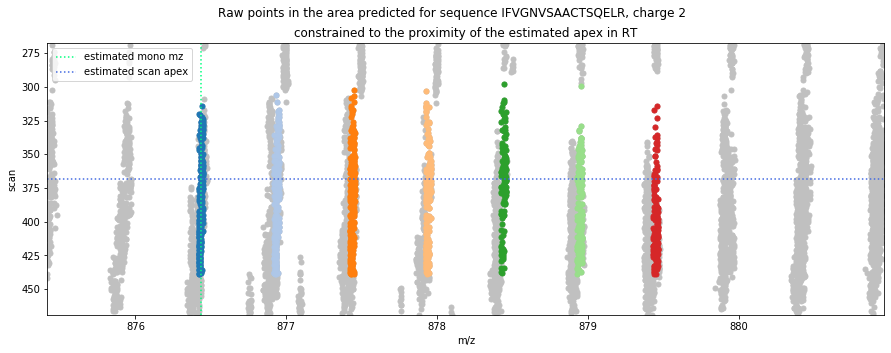

In [874]:
f, ax = plt.subplots()
ax.plot(wide_feature_region_raw_points_df.mz, wide_feature_region_raw_points_df.scan, marker='o', color='silver', linestyle='', ms=5)
for idx,isotope_raw_df in enumerate(isotope_raw_points_l):
    visualise_df = isotope_raw_df[(isotope_raw_df.retention_time_secs >= rt_wide_lower) & (isotope_raw_df.retention_time_secs <= rt_wide_upper)]
    ax.plot(visualise_df.mz, visualise_df.scan, marker='o', color=tableau20[idx], linestyle='', ms=5)
plt.axvline(x=estimated_monoisotopic_mz, linestyle=':', color='springgreen', label='estimated mono mz')
plt.axhline(y=estimated_scan_apex, linestyle=':', color='royalblue', label='estimated scan apex')
plt.xlabel('m/z')
plt.ylabel('scan')
plt.legend(loc='best')
plt.gca().invert_yaxis()
f.set_figheight(5)
f.set_figwidth(15)
plt.suptitle('Raw points in the area predicted for sequence {}, charge {}'.format(sequence_name, sequence_charge))
plt.title('constrained to the proximity of the estimated apex in RT')
plt.xlim((feature_region_mz_wide_lower,feature_region_mz_wide_upper))
plt.ylim((scan_wide_upper,scan_wide_lower))
plt.margins(0.06)
plt.show()

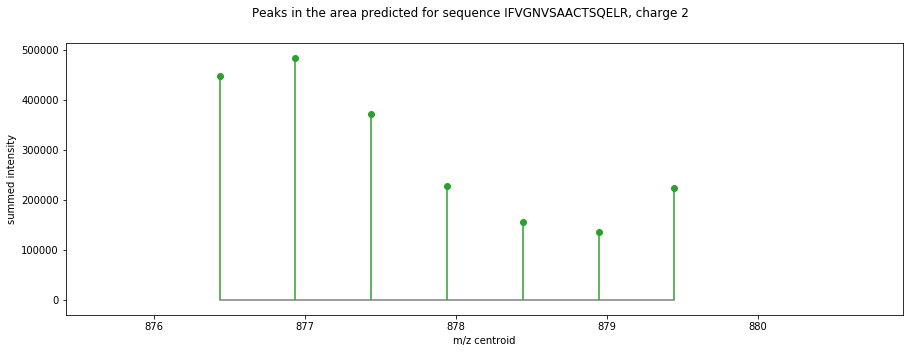

In [875]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markerline, stemlines, baseline = ax.stem(isotope_peaks_df.mz_centroid, isotope_peaks_df.summed_intensity, 'g', use_line_collection=True)
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])
plt.xlabel('m/z centroid')
plt.ylabel('summed intensity')
plt.xlim((feature_region_mz_wide_lower,feature_region_mz_wide_upper))
f.set_figheight(5)
f.set_figwidth(15)
plt.margins(0.06)
plt.suptitle('Peaks in the area predicted for sequence {}, charge {}'.format(sequence_name, sequence_charge))
plt.show()

#### Monoisotopic peak
We have confidence in the accuracy of each dimension in decreasing order: m/z, RT, scan. Therefore we constrain the cuboid by m/z first to find the peak in RT, then constrain the points to the RT peak's FWHM, then find the peak in the scan dimension.

In [876]:
mono_raw_points_df = isotope_raw_points_l[0]

Collapse the points onto the RT dimension

In [877]:
rt_0_df = mono_raw_points_df.groupby(['frame_id','retention_time_secs'], as_index=False).intensity.sum()
rt_0_df.sort_values(by=['retention_time_secs'], ascending=True, inplace=True)
rt_0_df['x'] = rt_0_df.retention_time_secs
rt_0_metrics = calculate_isotope_metrics(rt_0_df, estimated_rt_apex, RT_WIDTH)

there are 2 peaks


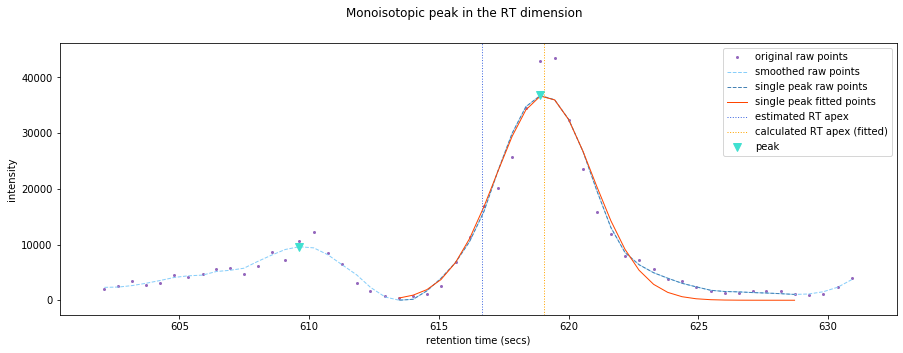

In [878]:
f, ax = plt.subplots()
# plot the original raw data
ax.plot(rt_0_df.retention_time_secs, rt_0_df.intensity, marker='o', color='tab:purple', linestyle='', linewidth=2, ms=2, label='original raw points')
# plot the filtered intensity values
ax.plot(rt_0_df.retention_time_secs, rt_0_metrics['original_intensity_filtered'], marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed raw points')
# plot the original filtered data constrained to a single peak
ax.plot(rt_0_metrics['fitted_curve_df'].retention_time_secs, rt_0_metrics['fitted_curve_df'].filtered_intensity, marker='', color='steelblue', linestyle='--', linewidth=1, ms=5, label='single peak raw points')
# plot the fitted curve
ax.plot(rt_0_metrics['fitted_curve_df'].retention_time_secs, rt_0_metrics['fitted_curve_df'].fitted_intensity, marker='', color='orangered', linestyle='-', linewidth=1, ms=5, label='single peak fitted points')
# show the estimated apex
plt.axvline(x=estimated_rt_apex, linestyle=':', color='royalblue', linewidth=1, label='estimated RT apex')
# show the calculated apex
plt.axvline(x=rt_0_metrics['apex'], linestyle=':', color='orange', linewidth=1, label='calculated RT apex (fitted)')
# show the peaks if there's more than one
if rt_0_metrics['number_of_peaks'] > 1:
    peak_idxs = rt_0_metrics['peak_maxima_indexes']
    ax.plot(rt_0_df.retention_time_secs.iloc[peak_idxs], rt_0_metrics['original_intensity_filtered'][peak_idxs], marker='v', color='turquoise', linestyle='', markeredgewidth=1, ms=8, label='peak')
plt.xlabel('retention time (secs)')
plt.ylabel('intensity')
plt.legend(loc='best')
f.set_figheight(5)
f.set_figwidth(15)
# plt.xlim((rt_0_metrics['base_lower'],rt_0_metrics['base_upper']))
plt.suptitle('Monoisotopic peak in the RT dimension')
plt.margins(0.06)
plt.show()

Collapse the points onto the mobility dimension, constraining the points to the FWHM of the peak in RT

In [879]:
rt_peak_fwhm_lower = rt_0_metrics['apex'] - (rt_0_metrics['full_width_half_max'])
rt_peak_fwhm_upper = rt_0_metrics['apex'] + (rt_0_metrics['full_width_half_max'])
mono_raw_points_df = mono_raw_points_df[(mono_raw_points_df.retention_time_secs >= rt_peak_fwhm_lower) & (mono_raw_points_df.retention_time_secs <= rt_peak_fwhm_upper)]

In [880]:
scan_0_df = mono_raw_points_df.groupby(['scan'], as_index=False).intensity.sum()
scan_0_df.sort_values(by=['scan'], ascending=True, inplace=True)
scan_0_df['x'] = scan_0_df.scan
scan_0_metrics = calculate_isotope_metrics(scan_0_df, estimated_scan_apex, SCAN_WIDTH)

there are 6 peaks


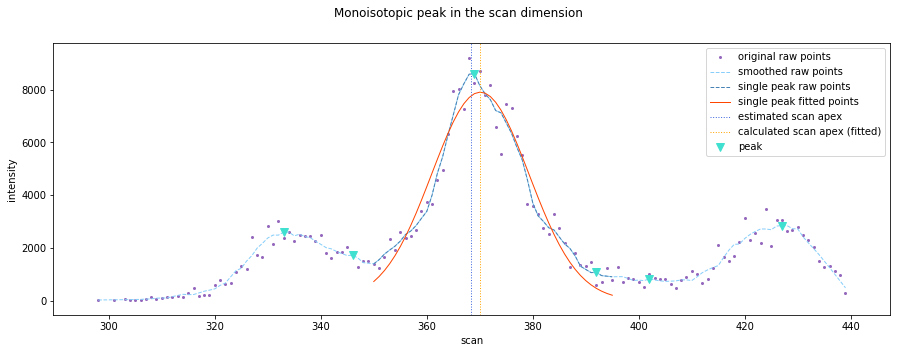

In [881]:
f, ax = plt.subplots()
# plot the original raw data
ax.plot(scan_0_df.scan, scan_0_df.intensity, marker='o', color='tab:purple', linestyle='', linewidth=2, ms=2, label='original raw points')
# plot the filtered intensity values
ax.plot(scan_0_df.scan, scan_0_metrics['original_intensity_filtered'], marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed raw points')
# plot the original filtered data constrained to a single peak
ax.plot(scan_0_metrics['fitted_curve_df'].scan, scan_0_metrics['fitted_curve_df'].filtered_intensity, marker='', color='steelblue', linestyle='--', linewidth=1, ms=5, label='single peak raw points')
# plot the fitted curve
ax.plot(scan_0_metrics['fitted_curve_df'].scan, scan_0_metrics['fitted_curve_df'].fitted_intensity, marker='', color='orangered', linestyle='-', linewidth=1, ms=5, label='single peak fitted points')
# show the estimated apex
plt.axvline(x=estimated_scan_apex, linestyle=':', color='royalblue', linewidth=1, label='estimated scan apex')
# show the calculated apex
plt.axvline(x=scan_0_metrics['apex'], linestyle=':', color='orange', linewidth=1, label='calculated scan apex (fitted)')
# show the peaks if there's more than one
if scan_0_metrics['number_of_peaks'] > 1:
    peak_idxs = scan_0_metrics['peak_maxima_indexes']
    ax.plot(scan_0_df.scan.iloc[peak_idxs], scan_0_metrics['original_intensity_filtered'][peak_idxs], marker='v', color='turquoise', linestyle='', markeredgewidth=1, ms=8, label='peak')
plt.xlabel('scan')
plt.ylabel('intensity')
plt.legend(loc='best')
f.set_figheight(5)
f.set_figwidth(15)
plt.suptitle('Monoisotopic peak in the scan dimension')
plt.margins(0.06)
plt.show()

#### Isotope 1 peak

In [882]:
isotope_1_raw_points_df = isotope_raw_points_l[1]

Collapse the points onto the RT dimension

In [883]:
rt_1_df = isotope_1_raw_points_df.groupby(['frame_id','retention_time_secs'], as_index=False).intensity.sum()
rt_1_df.sort_values(by=['retention_time_secs'], ascending=True, inplace=True)
rt_1_df['x'] = rt_1_df.retention_time_secs
rt_1_metrics = calculate_isotope_metrics(rt_1_df, estimated_rt_apex, RT_WIDTH)

there are 2 peaks


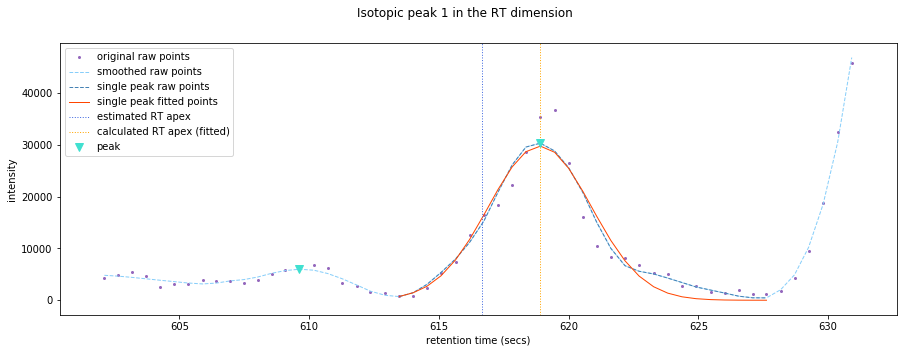

In [884]:
f, ax = plt.subplots()
# plot the original raw data
ax.plot(rt_1_df.retention_time_secs, rt_1_df.intensity, marker='o', color='tab:purple', linestyle='', linewidth=2, ms=2, label='original raw points')
# plot the filtered intensity values
ax.plot(rt_1_df.retention_time_secs, rt_1_metrics['original_intensity_filtered'], marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed raw points')
# plot the original filtered data constrained to a single peak
ax.plot(rt_1_metrics['fitted_curve_df'].retention_time_secs, rt_1_metrics['fitted_curve_df'].filtered_intensity, marker='', color='steelblue', linestyle='--', linewidth=1, ms=5, label='single peak raw points')
# plot the fitted curve
ax.plot(rt_1_metrics['fitted_curve_df'].retention_time_secs, rt_1_metrics['fitted_curve_df'].fitted_intensity, marker='', color='orangered', linestyle='-', linewidth=1, ms=5, label='single peak fitted points')
# show the estimated apex
plt.axvline(x=estimated_rt_apex, linestyle=':', color='royalblue', linewidth=1, label='estimated RT apex')
# show the calculated apex
plt.axvline(x=rt_1_metrics['apex'], linestyle=':', color='orange', linewidth=1, label='calculated RT apex (fitted)')
# show the peaks if there's more than one
if rt_1_metrics['number_of_peaks'] > 1:
    peak_idxs = rt_1_metrics['peak_maxima_indexes']
    ax.plot(rt_1_df.retention_time_secs.iloc[peak_idxs], rt_1_metrics['original_intensity_filtered'][peak_idxs], marker='v', color='turquoise', linestyle='', markeredgewidth=1, ms=8, label='peak')
plt.xlabel('retention time (secs)')
plt.ylabel('intensity')
plt.legend(loc='best')
f.set_figheight(5)
f.set_figwidth(15)
# plt.xlim((rt_0_metrics['base_lower'],rt_0_metrics['base_upper']))
plt.suptitle('Isotopic peak 1 in the RT dimension')
plt.margins(0.06)
plt.show()

Collapse the points onto the mobility dimension

In [885]:
rt_peak_fwhm_lower = rt_1_metrics['apex'] - rt_1_metrics['full_width_half_max']
rt_peak_fwhm_upper = rt_1_metrics['apex'] + rt_1_metrics['full_width_half_max']
isotope_1_raw_points_df = isotope_1_raw_points_df[(isotope_1_raw_points_df.retention_time_secs >= rt_peak_fwhm_lower) & (isotope_1_raw_points_df.retention_time_secs <= rt_peak_fwhm_upper)]

In [886]:
scan_1_df = isotope_1_raw_points_df.groupby(['scan'], as_index=False).intensity.sum()
scan_1_df.sort_values(by=['scan'], ascending=True, inplace=True)
scan_1_df['x'] = scan_1_df.scan
scan_1_metrics = calculate_isotope_metrics(scan_1_df, estimated_scan_apex, SCAN_WIDTH)

there are 5 peaks


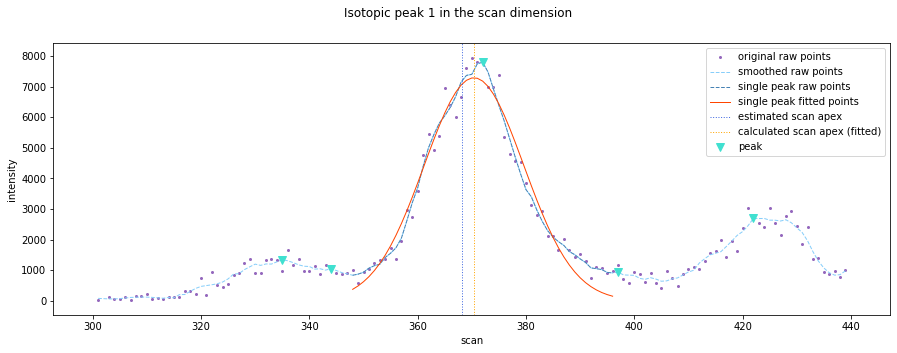

In [887]:
f, ax = plt.subplots()
# plot the original raw data
ax.plot(scan_1_df.scan, scan_1_df.intensity, marker='o', color='tab:purple', linestyle='', linewidth=2, ms=2, label='original raw points')
# plot the filtered intensity values
ax.plot(scan_1_df.scan, scan_1_metrics['original_intensity_filtered'], marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed raw points')
# plot the original filtered data constrained to a single peak
ax.plot(scan_1_metrics['fitted_curve_df'].scan, scan_1_metrics['fitted_curve_df'].filtered_intensity, marker='', color='steelblue', linestyle='--', linewidth=1, ms=5, label='single peak raw points')
# plot the fitted curve
ax.plot(scan_1_metrics['fitted_curve_df'].scan, scan_1_metrics['fitted_curve_df'].fitted_intensity, marker='', color='orangered', linestyle='-', linewidth=1, ms=5, label='single peak fitted points')
# show the estimated apex
plt.axvline(x=estimated_scan_apex, linestyle=':', color='royalblue', linewidth=1, label='estimated scan apex')
# show the calculated apex
plt.axvline(x=scan_1_metrics['apex'], linestyle=':', color='orange', linewidth=1, label='calculated scan apex (fitted)')
# show the peaks if there's more than one
if scan_1_metrics['number_of_peaks'] > 1:
    peak_idxs = scan_1_metrics['peak_maxima_indexes']
    ax.plot(scan_1_df.scan.iloc[peak_idxs], scan_1_metrics['original_intensity_filtered'][peak_idxs], marker='v', color='turquoise', linestyle='', markeredgewidth=1, ms=8, label='peak')
plt.xlabel('scan')
plt.ylabel('intensity')
plt.legend(loc='best')
f.set_figheight(5)
f.set_figwidth(15)
plt.suptitle('Isotopic peak 1 in the scan dimension')
plt.margins(0.06)
plt.show()

#### Isotope 2 peak

In [888]:
isotope_2_raw_points_df = isotope_raw_points_l[2]

Collapse the points onto the RT dimension

In [889]:
rt_2_df = isotope_2_raw_points_df.groupby(['frame_id','retention_time_secs'], as_index=False).intensity.sum()
rt_2_df.sort_values(by=['retention_time_secs'], ascending=True, inplace=True)
rt_2_df['x'] = rt_2_df.retention_time_secs
rt_2_metrics = calculate_isotope_metrics(rt_2_df, estimated_rt_apex, RT_WIDTH)

there are 2 peaks


In [890]:
len(rt_2_df)

54

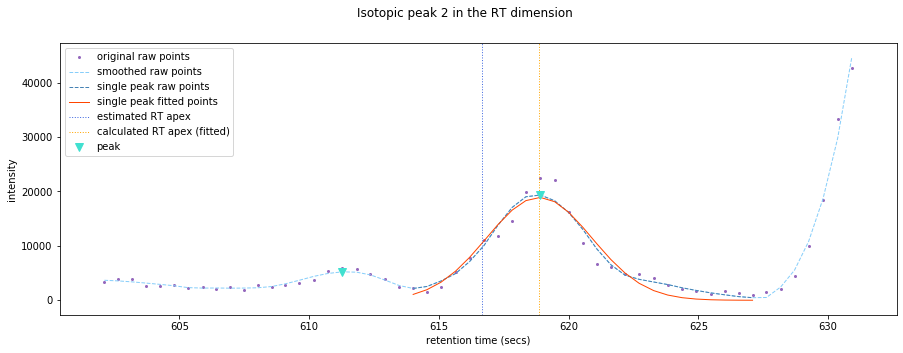

In [891]:
f, ax = plt.subplots()
# plot the original raw data
ax.plot(rt_2_df.retention_time_secs, rt_2_df.intensity, marker='o', color='tab:purple', linestyle='', linewidth=2, ms=2, label='original raw points')
# plot the filtered intensity values
ax.plot(rt_2_df.retention_time_secs, rt_2_metrics['original_intensity_filtered'], marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed raw points')
# plot the original filtered data constrained to a single peak
ax.plot(rt_2_metrics['fitted_curve_df'].retention_time_secs, rt_2_metrics['fitted_curve_df'].filtered_intensity, marker='', color='steelblue', linestyle='--', linewidth=1, ms=5, label='single peak raw points')
# plot the fitted curve
ax.plot(rt_2_metrics['fitted_curve_df'].retention_time_secs, rt_2_metrics['fitted_curve_df'].fitted_intensity, marker='', color='orangered', linestyle='-', linewidth=1, ms=5, label='single peak fitted points')
# show the estimated apex
plt.axvline(x=estimated_rt_apex, linestyle=':', color='royalblue', linewidth=1, label='estimated RT apex')
# show the calculated apex
plt.axvline(x=rt_2_metrics['apex'], linestyle=':', color='orange', linewidth=1, label='calculated RT apex (fitted)')
# show the peaks if there's more than one
if rt_2_metrics['number_of_peaks'] > 1:
    peak_idxs = rt_2_metrics['peak_maxima_indexes']
    ax.plot(rt_2_df.retention_time_secs.iloc[peak_idxs], rt_2_metrics['original_intensity_filtered'][peak_idxs], marker='v', color='turquoise', linestyle='', markeredgewidth=1, ms=8, label='peak')
plt.xlabel('retention time (secs)')
plt.ylabel('intensity')
plt.legend(loc='best')
f.set_figheight(5)
f.set_figwidth(15)
# plt.xlim((rt_0_metrics['base_lower'],rt_0_metrics['base_upper']))
plt.suptitle('Isotopic peak 2 in the RT dimension')
plt.margins(0.06)
plt.show()

Collapse the points onto the mobility dimension

In [892]:
rt_peak_fwhm_lower = rt_2_metrics['apex'] - rt_2_metrics['full_width_half_max']
rt_peak_fwhm_upper = rt_2_metrics['apex'] + rt_2_metrics['full_width_half_max']
isotope_2_raw_points_df = isotope_2_raw_points_df[(isotope_2_raw_points_df.retention_time_secs >= rt_peak_fwhm_lower) & (isotope_2_raw_points_df.retention_time_secs <= rt_peak_fwhm_upper)]

In [893]:
scan_2_df = isotope_2_raw_points_df.groupby(['scan'], as_index=False).intensity.sum()
scan_2_df.sort_values(by=['scan'], ascending=True, inplace=True)
scan_2_df['x'] = scan_2_df.scan
scan_2_metrics = calculate_isotope_metrics(scan_2_df, estimated_scan_apex, SCAN_WIDTH)

there are 8 peaks


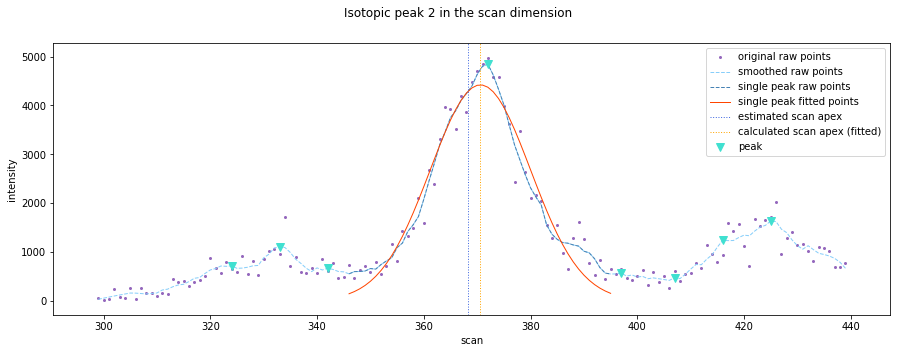

In [894]:
f, ax = plt.subplots()
# plot the original raw data
ax.plot(scan_2_df.scan, scan_2_df.intensity, marker='o', color='tab:purple', linestyle='', linewidth=2, ms=2, label='original raw points')
# plot the filtered intensity values
ax.plot(scan_2_df.scan, scan_2_metrics['original_intensity_filtered'], marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed raw points')
# plot the original filtered data constrained to a single peak
ax.plot(scan_2_metrics['fitted_curve_df'].scan, scan_2_metrics['fitted_curve_df'].filtered_intensity, marker='', color='steelblue', linestyle='--', linewidth=1, ms=5, label='single peak raw points')
# plot the fitted curve
ax.plot(scan_2_metrics['fitted_curve_df'].scan, scan_2_metrics['fitted_curve_df'].fitted_intensity, marker='', color='orangered', linestyle='-', linewidth=1, ms=5, label='single peak fitted points')
# show the estimated apex
plt.axvline(x=estimated_scan_apex, linestyle=':', color='royalblue', linewidth=1, label='estimated scan apex')
# show the calculated apex
plt.axvline(x=scan_2_metrics['apex'], linestyle=':', color='orange', linewidth=1, label='calculated scan apex (fitted)')
# show the peaks if there's more than one
if scan_2_metrics['number_of_peaks'] > 1:
    peak_idxs = scan_2_metrics['peak_maxima_indexes']
    ax.plot(scan_2_df.scan.iloc[peak_idxs], scan_2_metrics['original_intensity_filtered'][peak_idxs], marker='v', color='turquoise', linestyle='', markeredgewidth=1, ms=8, label='peak')
plt.xlabel('scan')
plt.ylabel('intensity')
plt.legend(loc='best')
f.set_figheight(5)
f.set_figwidth(15)
plt.suptitle('Isotopic peak 2 in the scan dimension')
plt.margins(0.06)
plt.show()

#### Build a dictionary of the metrics

In [802]:
feature_metrics = {}

Calculate the feature metrics

In [803]:
calculated_monoisotopic_mz = isotope_peaks_df.iloc[0].mz_centroid
delta_mz_ppm = (calculated_monoisotopic_mz - estimated_monoisotopic_mz) / estimated_monoisotopic_mz * 1e6
feature_metrics['delta_mz_ppm'] = delta_mz_ppm

In [804]:
feature_metrics['delta_scan'] = scan_apex_fitted - estimated_scan_apex

NameError: name 'scan_apex_fitted' is not defined

In [ ]:
if rt_curve_fit:
    delta_rt = rt_apex_fitted - estimated_rt_apex
else:
    delta_rt = rt_apex_centroid - estimated_rt_apex
feature_metrics['delta_rt'] = delta_rt

Calculate the delta ppm of the de-isotoped first and second isotopic peaks

In [ ]:
# monoisotopic
monoisotopic_mz_centroid = isotope_peaks_df.iloc[0].mz_centroid

# first isotope
if isotope_peaks_df.iloc[1].summed_intensity > 0:
    isotope_1_mz_centroid = isotope_peaks_df.iloc[1].mz_centroid
else:
    isotope_1_mz_centroid = np.nan

# second isotope
if isotope_peaks_df.iloc[2].summed_intensity > 0:
    isotope_2_mz_centroid = isotope_peaks_df.iloc[2].mz_centroid
else:
    isotope_2_mz_centroid = np.nan

In [ ]:
isotope_0_1_mz_delta_ppm = (monoisotopic_mz_centroid - (isotope_1_mz_centroid - (1 * expected_spacing_mz))) / monoisotopic_mz_centroid * 1e6
feature_metrics['isotope_0_1_mz_delta_ppm'] = isotope_0_1_mz_delta_ppm

In [ ]:
isotope_0_2_mz_delta_ppm = (monoisotopic_mz_centroid - (isotope_2_mz_centroid - (2 * expected_spacing_mz))) / monoisotopic_mz_centroid * 1e6
feature_metrics['isotope_0_2_mz_delta_ppm'] = isotope_0_2_mz_delta_ppm

In [ ]:
isotope_1_raw_points_df = isotope_raw_points_l[1]
isotope_2_raw_points_df = isotope_raw_points_l[2]

Calculate the RT apex deltas for the first and second isotopes

In [ ]:
isotope_0_1_rt_delta = rt_1_apex - rt_apex
isotope_0_2_rt_delta = rt_2_apex - rt_apex
feature_metrics['isotope_0_1_rt_delta'] = isotope_0_1_rt_delta
feature_metrics['isotope_0_2_rt_delta'] = isotope_0_2_rt_delta

Calculate the scan apex deltas for the first and second isotopes

In [ ]:
isotope_0_1_scan_delta = scan_1_apex - scan_apex
isotope_0_2_scan_delta = scan_2_apex - scan_apex
feature_metrics['isotope_0_1_scan_delta'] = isotope_0_1_scan_delta
feature_metrics['isotope_0_2_scan_delta'] = isotope_0_2_scan_delta

In [ ]:
feature_metrics

In [ ]:
scan_isotope_0_int_isotope_int_sum = scan_0_intensity_apex / (scan_0_intensity_apex + scan_1_intensity_apex + scan_2_intensity_apex)